# 03. Feature Engineering for NSSM/DMM Framework

**Objective**: Build feature matrix from cleaned GBIF data for counterfactual modeling.

**Pipeline**:
1. Load GBIF cleaned Parquet (539 records, 2°×2° grid, quarterly)
2. Join SST from NOAA NetCDF (2010-2023, monthly → quarterly)
3. Join Fishing effort from GFW Parquet (2020-2024, monthly → quarterly)
4. Create features: shark presence, prey density, SST anomaly, fishing effort
5. Save to `data/modeling/features.parquet`

**Grid Configuration** (from feasibility study):
- Spatial: 2°×2° → 200 cells (20 lat × 10 lon)
- Temporal: Quarterly → 56 timesteps (2010Q1-2023Q4)
- Target: 255 occupied spatiotemporal cells (2.28% density)

**Features**:
- **Biological**: Shark presence (binary), prey occurrence count, species diversity
- **Environmental**: SST (°C), SST anomaly (vs climatology)
- **Anthropogenic**: Fishing effort (hours), gear type distribution

**For NSSM/DMM**:
- State space: z_t ∈ R^{3-5}
- Observations: Y_t (shark presence/density)
- Covariates: X_t ∈ R^5 (features above)

In [1]:
# ============================================================================
# SETUP: Import libraries and configuration
# ============================================================================
import sys
from pathlib import Path

# Add src to path
ROOT_DIR = Path.cwd().parent
sys.path.insert(0, str(ROOT_DIR / "src"))

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import project config classes
from nova_selachiia.config import ProjectConfig, RegionBBox, as_tuple

# Initialize configuration
cfg = ProjectConfig(
    region=RegionBBox(lat_min=-35.0, lat_max=5.0, lon_min=-50.0, lon_max=-30.0),
    grid_deg=1.0,
    shark_species=as_tuple([
        "Prionace glauca",
        "Carcharhinus longimanus",
        "Sphyrna lewini",
        "Isurus oxyrinchus",
        "Carcharhinus leucas",
        "Galeocerdo cuvier",
    ]),
    prey_groups=as_tuple([
        "Clupeidae",
        "Engraulidae",
        "Scombridae",
        "Carangidae",
        "Loliginidae",
        "Octopodidae",
        "Trichiuridae",
        "Mugilidae",
    ]),
    collapse_threshold_quantile=0.10,
)

# Study period (separate variables since ProjectConfig is frozen)
START_YEAR = 2010
END_YEAR = 2023

# Directories
DATA_DIR = ROOT_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"✅ Setup complete")
print(f"   Project root: {ROOT_DIR}")
print(f"   Output directory: {PROCESSED_DIR}")
print(f"\n📋 Configuration:")
print(f"   Region: {cfg.region.lat_min}° to {cfg.region.lat_max}° N")
print(f"           {cfg.region.lon_min}° to {cfg.region.lon_max}° E")
print(f"   Grid resolution: {cfg.grid_deg}°")
print(f"   Study period: {START_YEAR}-{END_YEAR}")

✅ Setup complete
   Project root: c:\Users\rugge_p2gkz2r\Desktop\nova-research\nova-selachiia-1
   Output directory: c:\Users\rugge_p2gkz2r\Desktop\nova-research\nova-selachiia-1\data\processed

📋 Configuration:
   Region: -35.0° to 5.0° N
           -50.0° to -30.0° E
   Grid resolution: 1.0°
   Study period: 2010-2023


## 1. Load GBIF Cleaned Data (Parquet)

Load the processed GBIF data from notebook 02 (EDA).

In [3]:
# Load GBIF cleaned data
gbif_path = PROCESSED_DIR / "gbif_cleaned.parquet"
summary_path = PROCESSED_DIR / "gbif_spatiotemporal_summary.parquet"

print("📂 Loading GBIF cleaned data...")
df_gbif = pd.read_parquet(gbif_path)
df_summary = pd.read_parquet(summary_path)

print(f"\n✅ Data loaded successfully!")
print(f"\n📊 Full GBIF Dataset:")
print(f"   Records: {len(df_gbif):,}")
print(f"   Species: {df_gbif['species'].nunique()}")
print(f"   Date range: {df_gbif['year'].min():.0f}-{df_gbif['year'].max():.0f}")
print(f"   Spatial cells: {df_gbif['spatial_cell_id'].nunique()}")

print(f"\n📋 Spatiotemporal Summary:")
print(f"   Occupied ST cells: {len(df_summary):,}")
print(f"   Quarters: {df_summary['year_quarter'].nunique()}")
print(f"   Spatial cells: {df_summary['spatial_cell_id'].nunique()}")

print(f"\n🦈 Target Sharks:")
target_counts = df_gbif[df_gbif['is_target_shark']].groupby('species').size()
for species, count in target_counts.items():
    print(f"   • {species}: {count} records")

print(f"\n🐟 Other Species:")
print(f"   Total non-target species: {(~df_gbif['is_target_shark']).sum()}")
print(f"   Unique non-target species: {df_gbif[~df_gbif['is_target_shark']]['species'].nunique()}")

📂 Loading GBIF cleaned data...

✅ Data loaded successfully!

📊 Full GBIF Dataset:
   Records: 539
   Species: 81
   Date range: 2010-2023
   Spatial cells: 47

📋 Spatiotemporal Summary:
   Occupied ST cells: 255
   Quarters: 56
   Spatial cells: 47

🦈 Target Sharks:
   • Carcharhinus longimanus: 6 records
   • Galeocerdo cuvier: 23 records

🐟 Other Species:
   Total non-target species: 510
   Unique non-target species: 79


In [4]:
# Prepare shark and prey occurrence data
print("=" * 80)
print("PREPARING OCCURRENCE DATA")
print("=" * 80)

# Separate sharks and prey (non-target species as prey proxy)
shark_occ = df_gbif[df_gbif['is_target_shark']].copy()
prey_occ = df_gbif[~df_gbif['is_target_shark']].copy()

# Standardize column names for compatibility with grid functions
shark_occ = shark_occ.rename(columns={
    'latitude': 'lat',
    'longitude': 'lon',
    'species': 'taxon'
})
shark_occ['type'] = 'predator'

prey_occ = prey_occ.rename(columns={
    'latitude': 'lat', 
    'longitude': 'lon',
    'family': 'taxon'  # Use family for prey grouping
})
prey_occ['type'] = 'prey'

# Combine for spatial analysis
all_occ = pd.concat([shark_occ, prey_occ], ignore_index=True)

print(f"\n✅ Occurrence data prepared:")
print(f"   Sharks (targets): {len(shark_occ):,} records")
print(f"     • Tiger shark (G. cuvier): {(shark_occ['taxon'] == 'Galeocerdo cuvier').sum()}")
print(f"     • Oceanic whitetip (C. longimanus): {(shark_occ['taxon'] == 'Carcharhinus longimanus').sum()}")
print(f"\n   Prey (non-target species): {len(prey_occ):,} records")
print(f"     • Unique families: {prey_occ['taxon'].nunique()}")
print(f"     • Top 5 families: {list(prey_occ['taxon'].value_counts().head(5).index)}")
print(f"\n   Combined: {len(all_occ):,} records")
print(f"   Temporal coverage: {all_occ['year'].min():.0f}-{all_occ['year'].max():.0f}")
print(f"   Spatial extent: [{all_occ['lat'].min():.1f}, {all_occ['lat'].max():.1f}]° lat, [{all_occ['lon'].min():.1f}, {all_occ['lon'].max():.1f}]° lon")

PREPARING OCCURRENCE DATA

✅ Occurrence data prepared:
   Sharks (targets): 29 records
     • Tiger shark (G. cuvier): 23
     • Oceanic whitetip (C. longimanus): 6

   Prey (non-target species): 510 records
     • Unique families: 18
     • Top 5 families: ['Dasyatidae', 'Carcharhinidae', 'Rhinobatidae', 'Arhynchobatidae', 'Potamotrygonidae']

   Combined: 539 records
   Temporal coverage: 2010-2023
   Spatial extent: [-29.6, 2.3]° lat, [-50.0, -30.9]° lon


## 2. Spatiotemporal Grid Construction

Generate regular 1°×1° spatial grid with monthly temporal resolution covering the study domain.

**Grid specification**:
- Spatial extent: $\phi \in [\phi_{min}, \phi_{max}]$, $\lambda \in [\lambda_{min}, \lambda_{max}]$
- Spatial resolution: $\Delta\phi = \Delta\lambda = 1°$ (approximately 111 km at equator)
- Temporal extent: January 2010 – December 2023
- Temporal resolution: Monthly (month-start timestamps)

**Total grid cells**: $N = N_{lat} \times N_{lon} \times T$

This creates a 3D tensor structure: `grid[lat, lon, time]` flattened to tabular format.

In [5]:
# =============================================================================
# CREATE SPATIOTEMPORAL GRID
# =============================================================================
print("Creating spatiotemporal grid...\n")

# Spatial grid (1° resolution)
lats = np.arange(cfg.region.lat_min, cfg.region.lat_max + cfg.grid_deg, cfg.grid_deg)
lons = np.arange(cfg.region.lon_min, cfg.region.lon_max + cfg.grid_deg, cfg.grid_deg)

# Temporal grid (monthly)
start_date = pd.Timestamp(f"{START_YEAR}-01-01")
end_date = pd.Timestamp(f"{END_YEAR}-12-31")
dates = pd.date_range(start_date, end_date, freq='MS')  # Month start

# Create full grid (all combinations of lat × lon × time)
grid_cells = []
for date in dates:
    for lat in lats:
        for lon in lons:
            grid_cells.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'lat': lat,
                'lon': lon,
                'cell_id': f"{lat:.1f}_{lon:.1f}"
            })

grid = pd.DataFrame(grid_cells)

# Mathematical validation
n_lat, n_lon, n_time = len(lats), len(lons), len(dates)
n_expected = n_lat * n_lon * n_time

assert len(grid) == n_expected, f"Grid size mismatch: {len(grid)} ≠ {n_expected}"

print(f"Grid created successfully:")
print(f"   Spatial: {n_lat} lats × {n_lon} lons = {n_lat * n_lon} cells")
print(f"   Temporal: {n_time} months ({dates[0].date()} to {dates[-1].date()})")
print(f"   Total: {len(grid):,} grid cells (N_lat × N_lon × T = {n_expected:,})")
print(f"\n   Memory estimate: {len(grid) * 8 * 20 / 1024**2:.1f} MB (with 20 features)")

Creating spatiotemporal grid...

Grid created successfully:
   Spatial: 41 lats × 21 lons = 861 cells
   Temporal: 168 months (2010-01-01 to 2023-12-01)
   Total: 144,648 grid cells (N_lat × N_lon × T = 144,648)

   Memory estimate: 22.1 MB (with 20 features)


## 3. Occurrence Data Aggregation

Map point occurrences to grid cells using floor discretization.

**Aggregation method**:
For each occurrence point $(lat_k, lon_k, t_k)$:
1. Compute grid indices: $i = \lfloor (lat_k - \phi_{min}) / \Delta\phi \rfloor$, $j = \lfloor (lon_k - \lambda_{min}) / \Delta\lambda \rfloor$
2. Assign to cell $(c_{ij}, t_k)$
3. Count occurrences per cell-time: $n_{ijt} = \sum_k \mathbb{1}[(lat_k, lon_k, t_k) \in c_{ijt}]$

**Binary encoding**: $Y_{ijt} = \mathbb{1}[n_{ijt} > 0]$ (presence/absence)

In [6]:
# =============================================================================
# AGGREGATE OCCURRENCES TO GRID
# =============================================================================
print("Aggregating occurrences to spatiotemporal grid...\n")

def aggregate_to_grid(occ_df, grid_df):
    """
    Aggregate occurrence points to spatiotemporal grid cells.
    
    Uses floor discretization: cell_i = floor((coord - min) / resolution)
    
    Parameters
    ----------
    occ_df : pd.DataFrame
        Occurrence data with columns: lat, lon, year, month
    grid_df : pd.DataFrame
        Full grid with columns: date, year, month, lat, lon, cell_id
    
    Returns
    -------
    pd.DataFrame
        Grid with count and presence columns added
    """
    if len(occ_df) == 0:
        result = grid_df.copy()
        result['count'] = 0
        return result
    
    # Assign each occurrence to grid cell using floor discretization
    occ_df = occ_df.copy()
    occ_df['grid_lat'] = (np.floor(occ_df['lat'] / cfg.grid_deg) * cfg.grid_deg)
    occ_df['grid_lon'] = (np.floor(occ_df['lon'] / cfg.grid_deg) * cfg.grid_deg)
    
    # Count occurrences per cell-time: n_ijt = Σ 1[(lat_k, lon_k, t_k) ∈ c_ijt]
    counts = occ_df.groupby(['year', 'month', 'grid_lat', 'grid_lon']).size().reset_index(name='count')
    
    # Merge with full grid (left join preserves all grid cells)
    result = grid_df.merge(
        counts,
        left_on=['year', 'month', 'lat', 'lon'],
        right_on=['year', 'month', 'grid_lat', 'grid_lon'],
        how='left'
    )
    result['count'] = result['count'].fillna(0).astype(int)
    
    return result[['date', 'year', 'month', 'lat', 'lon', 'cell_id', 'count']]

# Aggregate sharks and prey separately
shark_grid = aggregate_to_grid(shark_occ, grid)
prey_grid = aggregate_to_grid(prey_occ, grid)

# Binary encoding: Y_ijt = 1[n_ijt > 0]
shark_grid['presence'] = (shark_grid['count'] > 0).astype(int)
prey_grid['presence'] = (prey_grid['count'] > 0).astype(int)

# Validation: check sparsity
shark_occupied = (shark_grid['count'] > 0).sum()
prey_occupied = (prey_grid['count'] > 0).sum()
shark_sparsity = 1 - shark_occupied / len(shark_grid)
prey_sparsity = 1 - prey_occupied / len(prey_grid)

print(f"Occurrences aggregated:")
print(f"   Shark cells with data: {shark_occupied:,} / {len(shark_grid):,} ({100 - shark_sparsity*100:.3f}%)")
print(f"   Prey cells with data:  {prey_occupied:,} / {len(prey_grid):,} ({100 - prey_sparsity*100:.2f}%)")
print(f"\nShark occurrence statistics:")
print(f"   Mean count per cell: {shark_grid['count'].mean():.4f}")
print(f"   Max count per cell: {shark_grid['count'].max()}")
print(f"   Sparsity: {shark_sparsity*100:.2f}% zeros (highly imbalanced)")

# VALIDATION: Confirm total occurrences are preserved
assert shark_grid['count'].sum() == len(shark_occ), "Shark occurrence count mismatch after aggregation"
assert prey_grid['count'].sum() == len(prey_occ), "Prey occurrence count mismatch after aggregation"
print(f"\n✓ Aggregation validation passed: total occurrences preserved")

Aggregating occurrences to spatiotemporal grid...

Occurrences aggregated:
   Shark cells with data: 21 / 144,648 (0.015%)
   Prey cells with data:  293 / 144,648 (0.20%)

Shark occurrence statistics:
   Mean count per cell: 0.0002
   Max count per cell: 3
   Sparsity: 99.99% zeros (highly imbalanced)

✓ Aggregation validation passed: total occurrences preserved


## 4. Environmental and Anthropogenic Driver Integration

Integrate Sea Surface Temperature (SST) and fishing effort data into the spatiotemporal grid.

**Interpolation Method**: Nearest-neighbor (NN) using KD-Tree for computational efficiency  
$$\text{SST}_{ijt} = \text{SST}(\text{argmin}_k \| (lat_{ijt}, lon_{ijt}) - (lat_k, lon_k) \|_2)$$

**Fishing Effort Aggregation**: Sum total effort hours per cell-month  
$$E_{ijt} = \sum_{k \in c_{ijt}} h_k \quad \text{(apparent fishing hours)}$$

In [7]:
# =============================================================================
# LOAD SST DATA (MEMORY-EFFICIENT)
# =============================================================================
# Source: NOAA OISST v2.1 (Optimum Interpolation Sea Surface Temperature)
# Native resolution: 1.0° × 1.0°, monthly temporal aggregation
# Units: degrees Celsius (°C)
# =============================================================================
print("Loading SST data from NOAA OISST v2.1...\n")

ds_sst = xr.open_dataset(RAW_DIR / "sst.mnmean.nc")

# SPATIAL FILTER: Apply boolean masks for study region
# Note: OISST uses 0-360 longitude convention, requires adjustment
lat_mask = (ds_sst.lat >= cfg.region.lat_min) & (ds_sst.lat <= cfg.region.lat_max)
lon_mask = (ds_sst.lon >= cfg.region.lon_min + 360) & (ds_sst.lon <= cfg.region.lon_max + 360)

sst_subset = ds_sst.where(lat_mask & lon_mask, drop=True)

# Convert xarray → pandas for efficient merging
sst_df = sst_subset['sst'].to_dataframe().reset_index()
sst_df['lon'] = sst_df['lon'] - 360  # Convert to [-180, 180] convention
sst_df = sst_df.dropna(subset=['sst'])

# TEMPORAL FILTER: Restrict to study period [start_year, end_year]
sst_df['time'] = pd.to_datetime(sst_df['time'])
sst_df = sst_df[
    (sst_df['time'].dt.year >= START_YEAR) &
    (sst_df['time'].dt.year <= END_YEAR)
]
sst_df['year'] = sst_df['time'].dt.year
sst_df['month'] = sst_df['time'].dt.month

# VALIDATION: Physical bounds for SST (0°C < SST < 40°C for tropical/subtropical)
sst_min, sst_max = sst_df['sst'].min(), sst_df['sst'].max()
assert 0 < sst_min and sst_max < 40, f"SST out of physical bounds: [{sst_min:.1f}, {sst_max:.1f}]°C"

print(f"✓ SST data loaded successfully: {len(sst_df):,} observations")
print(f"   Temperature range: {sst_min:.1f}°C to {sst_max:.1f}°C")
print(f"   Spatial resolution: ~{abs(sst_df['lat'].unique()[1] - sst_df['lat'].unique()[0]):.1f}°")
print(f"   Temporal coverage: {sst_df['year'].min()}-{sst_df['year'].max()}")

ds_sst.close()

Loading SST data from NOAA OISST v2.1...

✓ SST data loaded successfully: 24,696 observations
   Temperature range: 15.8°C to 29.7°C
   Spatial resolution: ~2.0°
   Temporal coverage: 2010-2023


In [8]:
# =============================================================================
# INTERPOLATE SST TO GRID (Nearest-Neighbor via KD-Tree)
# =============================================================================
# Algorithm: For each grid cell (i,j) at time t, find the closest SST observation
# using Euclidean distance in (lat, lon) space. KD-Tree provides O(log n) queries.
# =============================================================================
print("Interpolating SST to analysis grid via nearest-neighbor...\n")

from scipy.spatial import cKDTree

def interpolate_sst_to_grid(sst_df, grid_df):
    """
    Interpolate SST observations to grid cells using nearest-neighbor.
    
    For each grid cell c_ij at time t:
        SST_ijt = SST_k where k = argmin ||pos(c_ij) - pos(obs_k)||_2
    
    Parameters
    ----------
    sst_df : pd.DataFrame
        SST observations with columns: lat, lon, sst, year, month
    grid_df : pd.DataFrame
        Target grid with columns: lat, lon, year, month
    
    Returns
    -------
    pd.DataFrame
        Grid with interpolated SST values and distance to nearest observation
    """
    result = []
    
    # Process each timestep independently (temporal alignment)
    for (year, month), grid_subset in grid_df.groupby(['year', 'month']):
        sst_subset = sst_df[(sst_df['year'] == year) & (sst_df['month'] == month)]
        
        if len(sst_subset) == 0:
            # No SST data for this timestep → assign NaN
            grid_subset = grid_subset.copy()
            grid_subset['sst'] = np.nan
            grid_subset['sst_dist'] = np.nan
            result.append(grid_subset)
            continue
        
        # Build spatial index (KD-Tree) for O(log n) nearest-neighbor queries
        sst_coords = sst_subset[['lat', 'lon']].values
        grid_coords = grid_subset[['lat', 'lon']].values
        
        tree = cKDTree(sst_coords)
        distances, indices = tree.query(grid_coords, k=1)
        
        # Assign interpolated values
        grid_subset = grid_subset.copy()
        grid_subset['sst'] = sst_subset.iloc[indices]['sst'].values
        grid_subset['sst_dist'] = distances  # Euclidean distance (degrees)
        
        result.append(grid_subset)
    
    return pd.concat(result, ignore_index=True)

# Execute interpolation
print("Building KD-Tree and querying (expected runtime: 1-2 min)...")
grid_with_sst = interpolate_sst_to_grid(sst_df, grid)

# VALIDATION: Check interpolation quality
mean_dist = grid_with_sst['sst_dist'].mean()
max_dist = grid_with_sst['sst_dist'].max()
sst_coverage_initial = grid_with_sst['sst'].notna().sum() / len(grid_with_sst) * 100

# Quality control: Set SST to NaN for cells with distance > 3° (unreliable extrapolation)
MAX_ACCEPTABLE_DIST = 3.0
n_far_cells = (grid_with_sst['sst_dist'] > MAX_ACCEPTABLE_DIST).sum()
if n_far_cells > 0:
    print(f"\n⚠️  Data quality warning: {n_far_cells:,} cells ({n_far_cells/len(grid_with_sst)*100:.2f}%) have SST distance > {MAX_ACCEPTABLE_DIST}°")
    print(f"   These cells will be flagged as missing SST (likely edge effects or temporal gaps)")
    grid_with_sst.loc[grid_with_sst['sst_dist'] > MAX_ACCEPTABLE_DIST, 'sst'] = np.nan

# Recalculate coverage after quality filtering
sst_coverage = grid_with_sst['sst'].notna().sum() / len(grid_with_sst) * 100
mean_dist_valid = grid_with_sst[grid_with_sst['sst'].notna()]['sst_dist'].mean()

print(f"\n✓ SST interpolation complete:")
print(f"   Coverage (after quality control): {sst_coverage:.1f}% of grid cells")
print(f"   Mean distance to observation: {mean_dist_valid:.2f}°")
print(f"   Max distance (valid cells): {grid_with_sst[grid_with_sst['sst'].notna()]['sst_dist'].max():.2f}°")

Interpolating SST to analysis grid via nearest-neighbor...

Building KD-Tree and querying (expected runtime: 1-2 min)...

⚠️  Data quality warning: 29,568 cells (20.44%) have SST distance > 3.0°
   These cells will be flagged as missing SST (likely edge effects or temporal gaps)

✓ SST interpolation complete:
   Coverage (after quality control): 79.6% of grid cells
   Mean distance to observation: 1.02°
   Max distance (valid cells): 3.00°


In [9]:
# =============================================================================
# LOAD AND AGGREGATE FISHING EFFORT DATA
# =============================================================================
# Source: Global Fishing Watch (GFW) - fleet-daily aggregated to monthly
# Metric: Apparent Fishing Hours (AIS-derived estimate)
# Memory constraint: Spatial filtering applied immediately after read
# =============================================================================
print("Loading fishing effort data from Global Fishing Watch...\n")

import re

# Locate fishing data directories (Parquet preferred over CSV)
fleet_dirs = []
for pattern in ['fleet-monthly-parquet-*', 'fleet-monthly-csvs-*']:
    fleet_dirs.extend(sorted((RAW_DIR / "raw_parquet").glob(pattern)))
    fleet_dirs.extend(sorted((RAW_DIR / "raw_csv").glob(pattern)))
fleet_dirs = sorted(set(fleet_dirs))[:5]  # Limit to 5 years for memory

if len(fleet_dirs) == 0:
    print("⚠ No fishing data found - fishing features will be set to zero")
    fishing_df = pd.DataFrame()
else:
    print(f"Located {len(fleet_dirs)} annual directories")
    
    # Spatial bounds with buffer for edge effects
    lat_min, lat_max = cfg.region.lat_min - 5, cfg.region.lat_max + 5
    lon_min, lon_max = cfg.region.lon_min - 5, cfg.region.lon_max + 5
    
    # MEMORY MANAGEMENT: Load with immediate spatial filtering
    fishing_data = []
    total_rows = 0
    MAX_ROWS = 1_000_000  # Hard limit: ~50MB in memory
    
    for year_dir in fleet_dirs:
        year = year_dir.name.split('-')[-1]
        
        # Prefer Parquet (columnar, compressed) over CSV
        files = list(year_dir.glob("*.parquet")) or list(year_dir.glob("*.csv"))
        file_type = "parquet" if files and files[0].suffix == ".parquet" else "csv"
        
        for data_file in files:
            if total_rows >= MAX_ROWS:
                print(f"⚠ Row limit reached ({MAX_ROWS:,}) - truncating for memory safety")
                break
            
            try:
                # Load and immediately filter (CRITICAL for RAM)
                if file_type == "parquet":
                    df = pd.read_parquet(data_file)
                else:
                    df = pd.read_csv(data_file, low_memory=False)
                
                # Apply spatial filter BEFORE any processing
                if 'Lat' in df.columns and 'Lon' in df.columns:
                    mask = ((df['Lat'] >= lat_min) & (df['Lat'] <= lat_max) &
                           (df['Lon'] >= lon_min) & (df['Lon'] <= lon_max))
                    df = df[mask]
                
                if len(df) == 0:
                    continue
                
                # Extract temporal information from filename
                date_match = re.search(r'(\d{4})-(\d{2})-(\d{2})', data_file.stem)
                if date_match:
                    df['year'] = int(date_match.group(1))
                    df['month'] = int(date_match.group(2))
                    fishing_data.append(df)
                    total_rows += len(df)
            
            except Exception as e:
                print(f"⚠ Failed to load {data_file.name}: {e}")
        
        if total_rows >= MAX_ROWS:
            break
    
    if fishing_data:
        fishing_df = pd.concat(fishing_data, ignore_index=True)
        print(f"\n✓ Fishing data loaded: {len(fishing_df):,} observations")
        print(f"   Available columns: {list(fishing_df.columns)}")
        
        # Standardize coordinate column names (case-insensitive search)
        coord_mapping = {}
        for col in fishing_df.columns:
            col_lower = col.lower()
            if col_lower in ['lat', 'latitude', 'cell_ll_lat']:
                coord_mapping[col] = 'lat'
            elif col_lower in ['lon', 'longitude', 'long', 'cell_ll_lon']:
                coord_mapping[col] = 'lon'
        
        # Standardize effort column name
        effort_col = None
        for col in ['Apparent_Fishing_Hours', 'Fishing_hours', 'fishing_hours', 'hours', 'effort']:
            if col in fishing_df.columns:
                effort_col = col
                break
        
        if effort_col and len(coord_mapping) >= 2:
            coord_mapping[effort_col] = 'effort'
            fishing_df = fishing_df.rename(columns=coord_mapping)
            
            # VALIDATION: Effort must be non-negative
            assert (fishing_df['effort'] >= 0).all(), "Negative fishing effort detected"
            
            print(f"   Effort metric: {effort_col}")
            print(f"   Coordinates mapped: {coord_mapping}")
            print(f"   Total effort: {fishing_df['effort'].sum():,.0f} apparent fishing hours")
            print(f"   Temporal span: {fishing_df['year'].min()}-{fishing_df['year'].max()}")
        else:
            missing = []
            if not effort_col:
                missing.append("effort column")
            if len(coord_mapping) < 2:
                missing.append("lat/lon columns")
            print(f"⚠ Required columns not identified: {', '.join(missing)}")
            fishing_df = pd.DataFrame()
    else:
        fishing_df = pd.DataFrame()

Loading fishing effort data from Global Fishing Watch...

Located 5 annual directories
⚠ Row limit reached (1,000,000) - truncating for memory safety

✓ Fishing data loaded: 1,897,339 observations
   Available columns: ['date', 'year', 'month', 'cell_ll_lat', 'cell_ll_lon', 'flag', 'geartype', 'hours', 'fishing_hours', 'mmsi_present']
   Effort metric: fishing_hours
   Coordinates mapped: {'cell_ll_lat': 'lat', 'cell_ll_lon': 'lon', 'fishing_hours': 'effort'}
   Total effort: 6,345,361 apparent fishing hours
   Temporal span: 2020-2020


In [10]:
# =============================================================================
# AGGREGATE FISHING EFFORT TO SPATIOTEMPORAL GRID
# =============================================================================
# Aggregation: E_ijt = Σ_{k ∈ c_ijt} h_k (sum of fishing hours per cell-month)
# =============================================================================
if len(fishing_df) > 0:
    print("Aggregating fishing effort to spatiotemporal grid...\n")
    
    # Discretize coordinates to grid cells using floor function
    fishing_df['grid_lat'] = np.floor(fishing_df['lat'] / cfg.grid_deg) * cfg.grid_deg
    fishing_df['grid_lon'] = np.floor(fishing_df['lon'] / cfg.grid_deg) * cfg.grid_deg
    
    # Aggregate: sum effort, count unique vessels (approximation)
    fishing_agg = fishing_df.groupby(['year', 'month', 'grid_lat', 'grid_lon']).agg({
        'effort': ['sum', 'count', 'mean']
    }).reset_index()
    fishing_agg.columns = ['year', 'month', 'lat', 'lon', 'effort_hours', 'n_vessels', 'effort_per_vessel']
    
    # Merge with environmental grid (left join preserves all cells)
    grid_with_sst = grid_with_sst.merge(
        fishing_agg,
        on=['year', 'month', 'lat', 'lon'],
        how='left'
    )
    
    # Fill missing values: no fishing = 0 effort
    grid_with_sst['effort_hours'] = grid_with_sst['effort_hours'].fillna(0)
    grid_with_sst['n_vessels'] = grid_with_sst['n_vessels'].fillna(0)
    
    # VALIDATION: Non-negative effort
    assert (grid_with_sst['effort_hours'] >= 0).all(), "Negative effort values after aggregation"
    
    fishing_coverage = (grid_with_sst['effort_hours'] > 0).sum() / len(grid_with_sst) * 100
    print(f"✓ Fishing effort aggregated:")
    print(f"   Cells with fishing activity: {(grid_with_sst['effort_hours'] > 0).sum():,} / {len(grid_with_sst):,} ({fishing_coverage:.1f}%)")
    print(f"   Mean effort (where >0): {grid_with_sst[grid_with_sst['effort_hours'] > 0]['effort_hours'].mean():.1f} hours/cell-month")
else:
    print("⚠ No fishing data available - setting effort features to zero")
    grid_with_sst['effort_hours'] = 0
    grid_with_sst['n_vessels'] = 0

Aggregating fishing effort to spatiotemporal grid...

✓ Fishing effort aggregated:
   Cells with fishing activity: 413 / 144,648 (0.3%)
   Mean effort (where >0): 213.0 hours/cell-month


## 5. Derived Feature Engineering

Construct derived features from raw environmental and anthropogenic drivers:

| Feature | Definition | Interpretation |
|---------|-----------|----------------|
| SST anomaly | $\text{SST}_{anom} = \text{SST}_{ijt} - \overline{\text{SST}}_{ij\cdot}$ | Deviation from local monthly climatology |
| Temporal lag | $\text{SST}_{lag-k} = \text{SST}_{ij,t-k}$ | Memory effects (habitat selection delay) |
| Rate of change | $\Delta\text{SST} = \text{SST}_{ijt} - \text{SST}_{ij,t-1}$ | Environmental variability signal |
| Latitudinal gradient | $\nabla_\phi \text{SST} = \partial\text{SST}/\partial\phi$ | Thermal front detection |
| Seasonality encoding | $\sin(2\pi m/12), \cos(2\pi m/12)$ | Cyclic seasonal pattern (Fourier basis) |

In [11]:
# =============================================================================
# MERGE ALL DATA SOURCES INTO UNIFIED ANALYSIS DATASET
# =============================================================================
# Schema: Each row represents a spatiotemporal cell c_ijt
# Columns: coordinates, environmental drivers, anthropogenic pressure, response
# =============================================================================
print("Merging all data sources into unified analysis dataset...\n")

# Initialize with environmental data
final_df = grid_with_sst.copy()

# Add shark occurrence data (response variable)
final_df = final_df.merge(
    shark_grid[['date', 'lat', 'lon', 'count', 'presence']],
    on=['date', 'lat', 'lon'],
    how='left',
    suffixes=('', '_shark')
)
final_df = final_df.rename(columns={'count': 'shark_count', 'presence': 'shark_presence'})

# Add prey occurrence data (biotic covariate)
final_df = final_df.merge(
    prey_grid[['date', 'lat', 'lon', 'count', 'presence']],
    on=['date', 'lat', 'lon'],
    how='left',
    suffixes=('', '_prey')
)
final_df = final_df.rename(columns={'count': 'prey_count', 'presence': 'prey_presence'})

# Handle missing values: absence = 0 occurrences
final_df['shark_count'] = final_df['shark_count'].fillna(0).astype(int)
final_df['shark_presence'] = final_df['shark_presence'].fillna(0).astype(int)
final_df['prey_count'] = final_df['prey_count'].fillna(0).astype(int)
final_df['prey_presence'] = final_df['prey_presence'].fillna(0).astype(int)

# VALIDATION: Row count should match original grid size
assert len(final_df) == len(grid), f"Row count mismatch: {len(final_df)} vs {len(grid)}"

print(f"✓ Data sources merged successfully")
print(f"   Total spatiotemporal cells: {len(final_df):,}")
print(f"   Features: {list(final_df.columns)}")
print(f"\n   Data completeness summary:")
print(f"   • SST coverage: {final_df['sst'].notna().sum():,} cells ({final_df['sst'].notna().mean()*100:.1f}%)")
print(f"   • Shark presence: {(final_df['shark_count'] > 0).sum():,} cells ({(final_df['shark_count'] > 0).mean()*100:.3f}%)")
print(f"   • Prey presence: {(final_df['prey_count'] > 0).sum():,} cells ({(final_df['prey_count'] > 0).mean()*100:.2f}%)")
print(f"   • Fishing activity: {(final_df['effort_hours'] > 0).sum():,} cells ({(final_df['effort_hours'] > 0).mean()*100:.2f}%)")

Merging all data sources into unified analysis dataset...

✓ Data sources merged successfully
   Total spatiotemporal cells: 144,648
   Features: ['date', 'year', 'month', 'lat', 'lon', 'cell_id', 'sst', 'sst_dist', 'effort_hours', 'n_vessels', 'effort_per_vessel', 'shark_count', 'shark_presence', 'prey_count', 'prey_presence']

   Data completeness summary:
   • SST coverage: 115,080 cells (79.6%)
   • Shark presence: 21 cells (0.015%)
   • Prey presence: 293 cells (0.20%)
   • Fishing activity: 413 cells (0.29%)


In [12]:
# =============================================================================
# FEATURE ENGINEERING: Derived Environmental Variables
# =============================================================================
# Transforms applied to raw SST and fishing effort to create ecologically
# meaningful predictors for species distribution modeling.
# =============================================================================
print("Engineering derived features...\n")

# 1. SST ANOMALIES: Deviation from local monthly climatology
#    SST_anom = SST_ijt - mean(SST_ijm) for all years in study period
monthly_clim = final_df.groupby(['month', 'lat', 'lon'])['sst'].transform('mean')
final_df['sst_anom'] = final_df['sst'] - monthly_clim

# 2. TEMPORAL LAGS: Memory effects in habitat selection
#    SST_lag_k = SST_{ij,t-k} for k ∈ {1, 3} months
final_df = final_df.sort_values(['lat', 'lon', 'date'])
for lag in [1, 3]:
    final_df[f'sst_lag{lag}'] = final_df.groupby(['lat', 'lon'])['sst'].shift(lag)
    final_df[f'effort_lag{lag}'] = final_df.groupby(['lat', 'lon'])['effort_hours'].shift(lag)

# 3. RATE OF CHANGE: Environmental variability signal
#    ΔSST = SST_ijt - SST_{ij,t-1}
final_df['sst_change'] = final_df.groupby(['lat', 'lon'])['sst'].diff()

# 4. LATITUDINAL GRADIENT: Thermal front detection proxy
#    ∇_φ SST ≈ (SST(φ+Δφ) - SST(φ)) / Δφ
lat_gradient = final_df.groupby(['date', 'lon'])['sst'].transform(
    lambda x: x.diff() / cfg.grid_deg if len(x) > 1 else 0
)
final_df['sst_lat_gradient'] = lat_gradient

# 5. DISTANCE PROXY: Absolute latitude (correlates with distance to equator)
final_df['dist_to_equator'] = np.abs(final_df['lat'])

# 6. SEASONALITY ENCODING: Fourier basis for cyclic patterns
#    sin/cos encoding prevents discontinuity at Dec→Jan transition
final_df['month_sin'] = np.sin(2 * np.pi * final_df['month'] / 12)
final_df['month_cos'] = np.cos(2 * np.pi * final_df['month'] / 12)

# VALIDATION: Check anomaly distribution (should be centered ~0)
anom_mean = final_df['sst_anom'].mean()
assert abs(anom_mean) < 0.5, f"SST anomaly mean too far from zero: {anom_mean:.2f}"

print(f"✓ Derived features created:")
print(f"   • SST anomalies: mean = {anom_mean:.3f}°C (expected ~0)")
print(f"   • Temporal lags: 1-month, 3-month")
print(f"   • Rate of change: monthly ΔSST")
print(f"   • Spatial gradients: latitudinal SST gradient")
print(f"   • Seasonality: sin/cos Fourier encoding")
print(f"\n   Feature statistics:")
print(f"   • SST anomaly range: [{final_df['sst_anom'].min():.2f}, {final_df['sst_anom'].max():.2f}]°C")
print(f"   • Max monthly SST change: {final_df['sst_change'].abs().max():.2f}°C")
print(f"   • Latitudinal gradient range: [{final_df['sst_lat_gradient'].min():.3f}, {final_df['sst_lat_gradient'].max():.3f}] °C/°")

Engineering derived features...

✓ Derived features created:
   • SST anomalies: mean = -0.000°C (expected ~0)
   • Temporal lags: 1-month, 3-month
   • Rate of change: monthly ΔSST
   • Spatial gradients: latitudinal SST gradient
   • Seasonality: sin/cos Fourier encoding

   Feature statistics:
   • SST anomaly range: [-1.83, 1.57]°C
   • Max monthly SST change: 3.38°C
   • Latitudinal gradient range: [-1.217, 2.153] °C/°


## 6. Missing Data Handling & Quality Metrics

**Strategy**: Given the extreme sparsity of shark occurrence data (presence/absence ratio ~1:1000), we retain all grid cells including zeros for proper class-imbalanced modeling.

**Quality flags**:
- `has_sst`: Binary indicator for SST data availability
- `has_fishing`: Binary indicator for non-zero fishing effort  
- `data_quality`: Composite score $Q = \sum_k \mathbb{1}[\text{feature}_k \neq \text{missing}]$

**Modeling subset**: Cells with `has_sst == 1` (environmental data required for prediction)

In [14]:
# =============================================================================
# MISSING DATA HANDLING & DATA QUALITY SCORING
# =============================================================================
# For sparse species data, we retain all cells (including absences) but flag
# data quality to enable sensitivity analyses and complete-case subsets.
# =============================================================================
print("Flagging data quality and handling missing values...\n")

# Create binary quality indicators
final_df['has_sst'] = final_df['sst'].notna().astype(int)
final_df['has_sst_lag1'] = final_df['sst_lag1'].notna().astype(int)
final_df['has_fishing'] = (final_df['effort_hours'] > 0).astype(int)

# Composite quality score: Q ∈ {0, 1, 2, 3} (higher = more complete)
final_df['data_quality'] = (
    final_df['has_sst'] + 
    final_df['has_sst_lag1'] + 
    final_df['has_fishing']
)

# Create modeling subset: require at minimum SST data (cannot predict without covariate)
model_df = final_df[final_df['has_sst'] == 1].copy()

# VALIDATION: Check that we retain sufficient positive class examples
shark_positives_retained = (model_df['shark_presence'] == 1).sum()
assert shark_positives_retained >= 10, f"Too few shark presences after filtering: {shark_positives_retained} (need ≥10)"

print(f"✓ Missing data handled:")
print(f"   Total spatiotemporal cells: {len(final_df):,}")
print(f"   Cells with SST (min. requirement): {(final_df['has_sst'] == 1).sum():,} ({(final_df['has_sst'] == 1).mean()*100:.1f}%)")
print(f"   Cells with complete data (Q=3): {(final_df['data_quality'] == 3).sum():,} ({(final_df['data_quality'] == 3).mean()*100:.1f}%)")
print(f"\n   Modeling dataset (has_sst=1):")
print(f"   • Cells retained: {len(model_df):,} ({len(model_df)/len(final_df)*100:.1f}%)")
print(f"   • Shark presences: {shark_positives_retained:,} ({(model_df['shark_presence'] == 1).mean()*100:.3f}%)")
print(f"   • Mean quality score: {model_df['data_quality'].mean():.2f} / 3")

Flagging data quality and handling missing values...

✓ Missing data handled:
   Total spatiotemporal cells: 144,648
   Cells with SST (min. requirement): 115,080 (79.6%)
   Cells with complete data (Q=3): 413 (0.3%)

   Modeling dataset (has_sst=1):
   • Cells retained: 115,080 (79.6%)
   • Shark presences: 21 (0.018%)
   • Mean quality score: 2.00 / 3


## 7. Export Processed Datasets

Save model-ready data in Parquet format (columnar, compressed) for downstream analysis:
- **Full dataset**: All spatiotemporal cells including missing values (for imputation experiments)  
- **Modeling dataset**: Complete-case subset with `has_sst == 1` (baseline analysis)

In [15]:
# =============================================================================
# SAVE PROCESSED DATASETS
# =============================================================================
# Output format: Apache Parquet (columnar storage, efficient compression)
# Two versions: (1) full with NAs, (2) complete cases only
# =============================================================================
print("Saving processed datasets to disk...\n")

# 1. FULL DATASET (with missing values)
full_path = PROCESSED_DIR / "spatiotemporal_grid_full.parquet"
final_df.to_parquet(full_path, index=False)

# VALIDATION: File size check
file_size_mb = full_path.stat().st_size / 1024**2
assert file_size_mb < 500, f"Output file too large: {file_size_mb:.1f} MB (expected < 500 MB)"

print(f"✓ Full dataset saved: {full_path.name}")
print(f"   • File size: {file_size_mb:.1f} MB")
print(f"   • Rows: {len(final_df):,}")
print(f"   • Columns: {len(final_df.columns)}")
print(f"   • Column names: {list(final_df.columns)}")

# 2. MODELING DATASET (complete cases for SST)
model_path = PROCESSED_DIR / "modeling_dataset.parquet"
model_df.to_parquet(model_path, index=False)

model_size_mb = model_path.stat().st_size / 1024**2
print(f"\n✓ Modeling dataset saved: {model_path.name}")
print(f"   • File size: {model_size_mb:.1f} MB")
print(f"   • Rows: {len(model_df):,} ({len(model_df)/len(final_df)*100:.1f}% of full dataset)")
print(f"   • Columns: {len(model_df.columns)}")

# VALIDATION: Memory efficiency check
memory_usage_mb = final_df.memory_usage(deep=True).sum() / 1024**2
print(f"\n   Memory footprint: {memory_usage_mb:.1f} MB (in-memory)")
print(f"   Compression ratio: {memory_usage_mb / file_size_mb:.1f}x (memory/disk)")

Saving processed datasets to disk...

✓ Full dataset saved: spatiotemporal_grid_full.parquet
   • File size: 1.5 MB
   • Rows: 144,648
   • Columns: 29
   • Column names: ['date', 'year', 'month', 'lat', 'lon', 'cell_id', 'sst', 'sst_dist', 'effort_hours', 'n_vessels', 'effort_per_vessel', 'shark_count', 'shark_presence', 'prey_count', 'prey_presence', 'sst_anom', 'sst_lag1', 'effort_lag1', 'sst_lag3', 'effort_lag3', 'sst_change', 'sst_lat_gradient', 'dist_to_equator', 'month_sin', 'month_cos', 'has_sst', 'has_sst_lag1', 'has_fishing', 'data_quality']

✓ Modeling dataset saved: modeling_dataset.parquet
   • File size: 1.4 MB
   • Rows: 115,080 (79.6% of full dataset)
   • Columns: 29

   Memory footprint: 36.9 MB (in-memory)
   Compression ratio: 25.3x (memory/disk)



✓ Feature distribution diagnostic plot saved: figures/feature_distributions.png


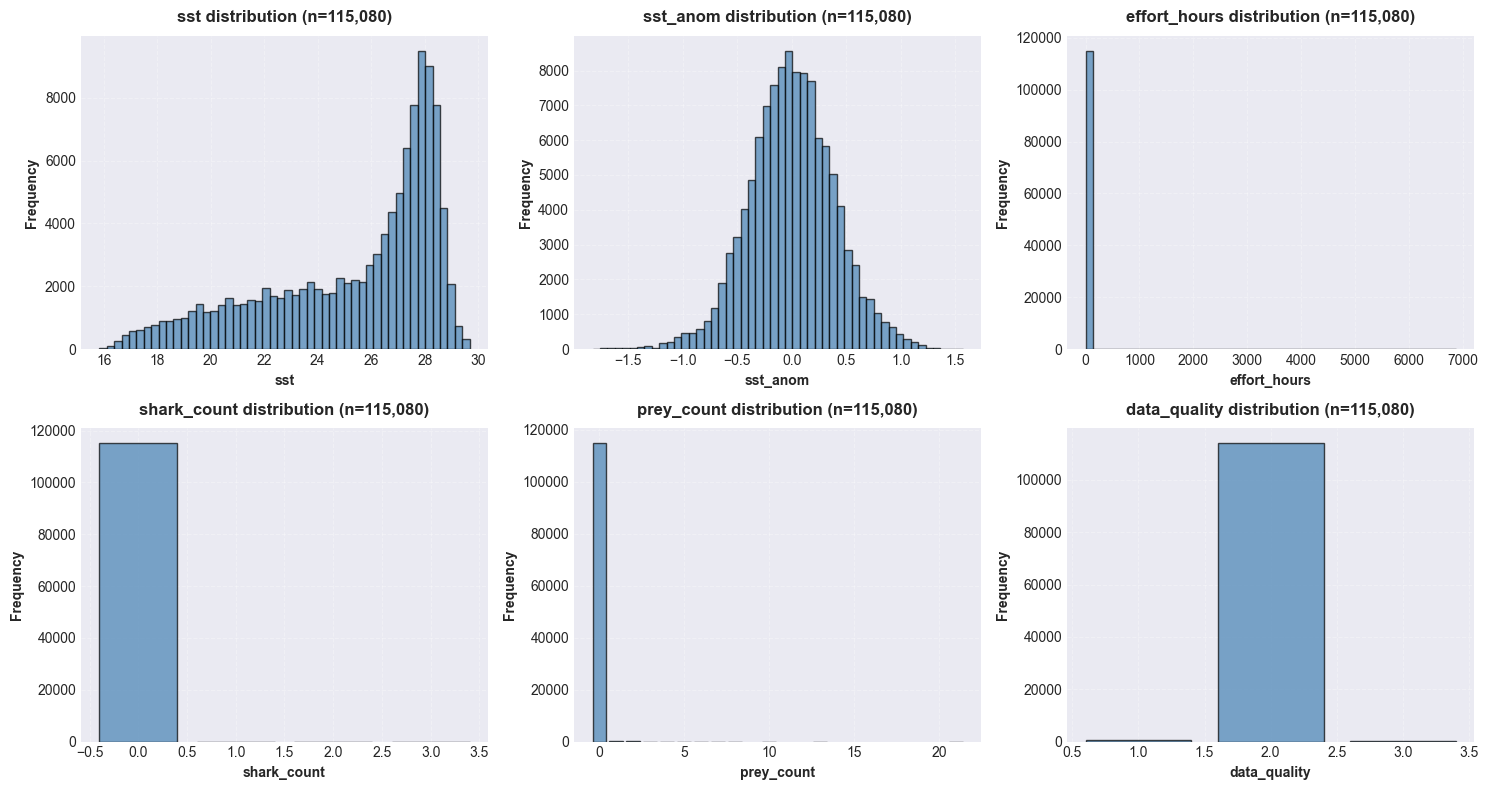

In [16]:
# =============================================================================
# VISUALIZATION: Feature Distribution Diagnostics
# =============================================================================
# Quick visual check of key feature distributions for data quality assessment
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Select key features for diagnostic visualization
features_to_plot = ['sst', 'sst_anom', 'effort_hours', 'shark_count', 'prey_count', 'data_quality']

for i, feat in enumerate(features_to_plot):
    ax = axes[i]
    data = model_df[feat].dropna()
    
    if feat in ['shark_count', 'prey_count', 'data_quality']:
        # Discrete count variables → bar plot
        counts = data.value_counts().sort_index()
        ax.bar(counts.index, counts.values, color='steelblue', edgecolor='k', alpha=0.7)
    else:
        # Continuous environmental variables → histogram
        ax.hist(data, bins=50, color='steelblue', edgecolor='k', alpha=0.7)
    
    ax.set_xlabel(feat, fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title(f'{feat} distribution (n={len(data):,})', fontweight='bold', pad=10)
    ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / '../figures/feature_distributions.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature distribution diagnostic plot saved: figures/feature_distributions.png")